In [1]:
using Healpix
using Plots
using NPZ
using LinearAlgebra
using LsqFit
using StatsBase
using BenchmarkTools
using PyCall
using TickTock
using Base.Threads
using StatsPlots
using PyPlot
using DSP
using FFTW
gr()

hp =  pyimport("healpy")
np = pyimport("numpy")
sns = pyimport("seaborn")
plt = pyimport("matplotlib.pyplot")
sp = pyimport("scipy.optimize")
nth = nthreads()# for parallerize

@inline function MultiTrack_calculation(
    NSIDE::Integer,
    start::Integer,
    stop::Integer,
    smp_rate::Integer,
    dθ::Array,
    dφ::Array,
)

    loop = ((stop - start) * smp_rate) + 1

    #println("time=",loop)
    res = Resolution(NSIDE)

    α = 45(π / 180)
    β = 50(π / 180)
    orbit3D = zeros(Float64, loop, 3)
    orbit2D = zeros(Float64, loop, 2)
    dif3D = zeros(Float64, loop-1, 3)
    dif2D = zeros(Float64, loop-1, 2)
    theta_axis3D = zeros(Float64, loop, 3)

    theta_axis = zeros(Float64, loop, 2)
    sky_axis = zeros(Float64, loop, 3)

    pix = zeros(Int64, loop, length(dθ))
    psi_i = zeros(Float64, loop, length(dθ))
    cb = cos(β)
    sb = sin(β)
    ca = cos(α)
    sa = sin(α)
    println("Start track calculation!")

    for j in eachindex(dθ)
        println("j=", j)
        origin =
            [cos(dθ[j]) * cos(dφ[j]); cos(dθ[j]) * sin(dφ[j]); sin(dθ[j])]

        @inbounds @threads for i in 1:loop
            t = start + (i-1)/smp_rate

            ωₐt = ((2π / 60) / 192.348)t
            ωᵦt = (0.05π / 30)t
            ωᵣt = (2π)t / (60 * 60 * 24 * 365)
            cwb = cos(ωᵦt)
            swb = sin(ωᵦt)
            cwa = cos(ωₐt)
            swa = sin(ωₐt)
            cwr = cos(ωᵣt)
            swr = sin(ωᵣt)

            rot_spin = [
                cb -sb 0
                sb*cwb cb*cwb -swb
                sb*swb cb*swb cwb
            ]
            vec_1 = @views rot_spin * origin

            rot_prec = [
                ca -sa 0
                sa*cwa ca*cwa -swa
                sa*swa ca*swa cwa
            ]
            vec_2 = @views rot_prec * vec_1

            rot_sun = [
                cwr -swr 0
                swr cwr 0
                0 0 1
            ]
            vec_3 = @views rot_sun * vec_2

            orbit3D[i, 1] = vec_3[1]
            orbit3D[i, 2] = vec_3[2]
            orbit3D[i, 3] = vec_3[3]

            ang = @views vec2ang(
                orbit3D[i, 1],
                orbit3D[i, 2],
                orbit3D[i, 3],
            )

            orbit2D[i, 1] = ang[1]
            orbit2D[i, 2] = ang[2]

            theta_axis[i, 1] = orbit2D[i, 1] + (π / 180) * 1e-7

            vec = @views ang2vec(theta_axis[i, 1], orbit2D[i, 2])
            sky_axis[i, 1] = vec[1] - orbit3D[i, 1]
            sky_axis[i, 2] = vec[2] - orbit3D[i, 2]
            sky_axis[i, 3] = vec[3] - orbit3D[i, 3]
            pix[i, j] = ang2pix(m, orbit2D[i, 1], orbit2D[i, 2])
        end

        @inbounds @threads for i in 1:loop-1
            dif3D[i, 1] = orbit3D[i+1, 1] - orbit3D[i, 1]
            dif3D[i, 2] = orbit3D[i+1, 2] - orbit3D[i, 2]
            dif3D[i, 3] = orbit3D[i+1, 3] - orbit3D[i, 3]
            dif2D[i, 1] = orbit2D[i+1, 1] - orbit2D[i, 1]
            dif2D[i, 2] = orbit2D[i+1, 2] - orbit2D[i, 2]

            Vvec = @views dif3D[i, :]
            nvec = @views sky_axis[i, :]
            inner = dot(Vvec, nvec)
            L_dif =
                √(dif3D[i, 1]^2 + dif3D[i, 2]^2 + dif3D[i, 3]^2)
            L_axis = √(
                sky_axis[i, 1]^2 +
                sky_axis[i, 2]^2 +
                sky_axis[i, 3]^2,
            )

            cos_psi = inner / (L_dif * L_axis)

            if dif2D[i, 2] > π
                dif2D[i, 2] = dif2D[i, 2] - 2π
            end
            if dif2D[i, 2] < -π
                dif2D[i, 2] = dif2D[i, 2] + 2π
            end

            judge = sign(-dif2D[i, 2])
            psi_i[i, j] = acos(cos_psi) * judge
        end
    end
    return pix, psi_i
end


function get_psi_and_pix(
    NSIDE::Integer,
    times::Integer,
    smp_rate::Integer,
    dθ::Array,
    dφ::Array,
)

    split_num = 6
    month = Int64(times/split_num)


    hit_pix = zeros(Int64, NPIX)
    theta_line_pix = Int64[]
    theta_line_psi = Float64[]

    Begin = 0
    
    deg = 90(π/180)
    dphi = 20(π/180)

    for i = 1:split_num
        println("process=", i, "/", split_num)
        stop = i*month

        #println("calc_", start, "_to_", stop)
        #println("Finish is =", times)
        PIX, PSI_i = MultiTrack_calculation(NSIDE, Begin, stop, smp_rate, dθ, dφ)

        loop_times = length(PSI_i[:, 1])
        println("Start reconstruct!")
        #println("loop_times=", loop_times)
        bore_pix = @views PIX[:, 1]
        ghost_pix = @views PIX[:, 2]
        psi_i = @views PSI_i[:, 1]
        
        pix_pi2 = hp.pix2ang(NSIDE, bore_pix)[2]
    
        for k in 1:loop_times
            bore = bore_pix[k]
            ghost = ghost_pix[k]
            psi = psi_i[k]
            TIME = Begin + (k-1)/smp_rate
            
            
            if pix_pi2[k] < deg + dphi
                if pix_pi2[k] > deg - dphi
                    push!(theta_line_pix, bore)
                    push!(theta_line_psi, psi)
                end
            end

            hit_pix[bore] += 1
        end
        Begin = stop + 1
    end
    
    return hit_pix, theta_line_pix, theta_line_psi
end

get_psi_and_pix (generic function with 1 method)

In [2]:
const NSIDE = 128
const NPIX = nside2npix(NSIDE)
const m = Map{Float64,RingOrder}(NSIDE)
const day = 60 * 60 * 24
const year = day * 365
smp_rate = 1
times = year

Ghost = 1
ghost_ang = Ghost * (pi / 180)

println("SR=", smp_rate)
println("GhostAng=", Ghost)

t1 = ghost_ang
p1 = ghost_ang

dth = [0, t1]
dph = [0, p1]


SR=1
GhostAng=1


2-element Array{Float64,1}:
 0.0
 0.017453292519943295

In [3]:
tick()
hit_pix, theta_line_pix, theta_line_psi = get_psi_and_pix(NSIDE, times, smp_rate, dth, dph)
tock()

┌ Info:  started timer at: 2020-08-26T16:34:00.333
└ @ TickTock /Users/yusuke/.julia/packages/TickTock/3F6de/src/TickTock.jl:32


process=1/6
Start track calculation!
j=1
j=2
Start reconstruct!
process=2/6
Start track calculation!
j=1
j=2
Start reconstruct!
process=3/6
Start track calculation!
j=1
j=2
Start reconstruct!
process=4/6
Start track calculation!
j=1
j=2
Start reconstruct!
process=5/6
Start track calculation!
j=1
j=2
Start reconstruct!
process=6/6
Start track calculation!
j=1
j=2
Start reconstruct!


┌ Info:        148.579034338s: 2 minutes, 28 seconds, 579 milliseconds
└ @ TickTock /Users/yusuke/.julia/packages/TickTock/3F6de/src/TickTock.jl:39


In [20]:
#Theta_line, phi90pix = MyPackage.lineget(NSIDE, theta_line_pix, theta_line_psi, 256)
div = 100
elev = np.linspace(0, π, div)
azim = ones(div) .* π / 2
phi90pix = hp.ang2pix(NSIDE, elev, azim)
#np.save("/Users/yusuke/program/LiteBIRD_sim/beam_study", phi90pix)

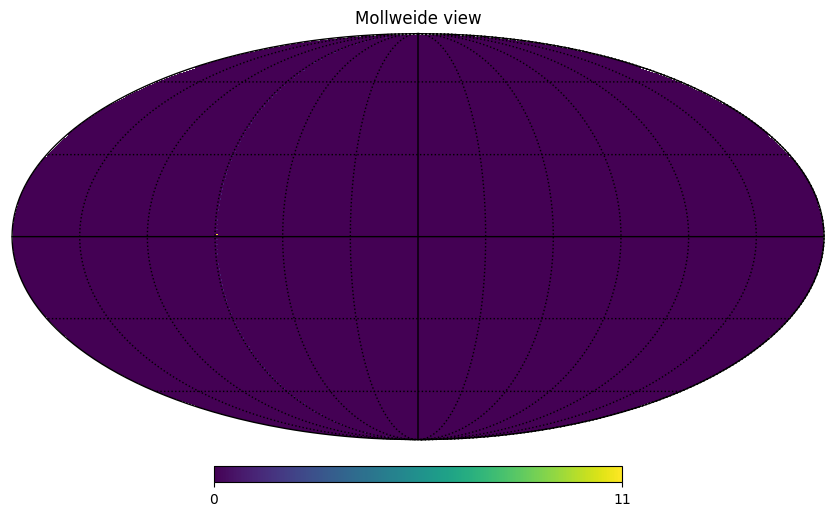

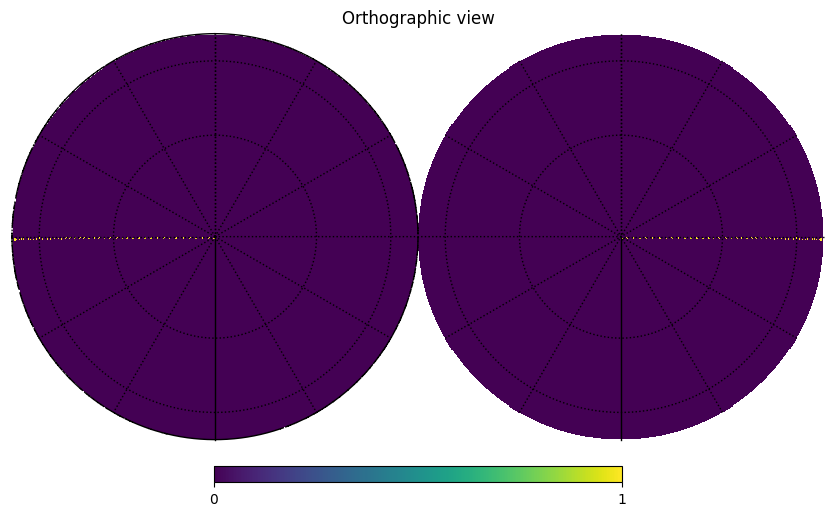

In [5]:
I_lu = zeros(NPIX)
for i in 1:length(phi90pix)
    if phi90pix[i] == 96640
        I_lu[phi90pix[i]] += 10
    end
    I_lu[phi90pix[i]] += 1
end

#Plots.plot(MyPackage.gen_map(NSIDE, I_lu), c=:jet)
hp.mollview(I_lu)
hp.graticule()
hp.orthview(I_lu, rot=(0,90))
hp.graticule()

In [7]:
using Pkg
Pkg.activate("/Users/yusuke/program/julia_module/MyPackage")
using MyPackage
hit_pix = MyPackage.hit_map(NPIX, theta_line_pix)
link1,link2,link3,link4 = MyPackage.cross_links(NPIX, theta_line_psi, theta_line_pix, hit_pix)
#=
Plots.plot(
    Plots.plot(MyPackage.gen_map(NSIDE, link1), seriescolor=:jet, title = "n=1"),
    Plots.plot(MyPackage.gen_map(NSIDE, link2), seriescolor=:jet, title = "n=2"),
    Plots.plot(MyPackage.gen_map(NSIDE, link3), seriescolor=:jet, title = "n=3"),
    Plots.plot(MyPackage.gen_map(NSIDE, link4), seriescolor=:jet, title = "n=4")
    )
=#

 Activating environment at `~/program/julia_module/MyPackage/Project.toml`
┌ Info: Precompiling MyPackage [ede99797-3c3e-4244-8c1d-969d4817000d]
└ @ Base loading.jl:1260


([NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN])

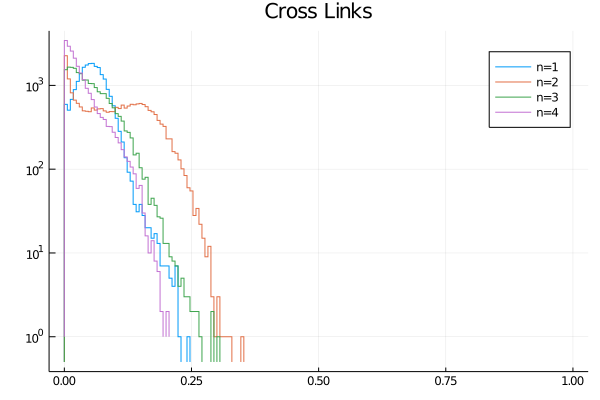

In [8]:
link1 = np.nan_to_num(link1,nan=-0.1)
link2 = np.nan_to_num(link2,nan=-0.1)
link3 = np.nan_to_num(link3,nan=-0.1)
link4 = np.nan_to_num(link4,nan=-0.1)
BINS=170
edge = 0:1/BINS:1
l1 = fit(Histogram, link1, edge)
l2 = fit(Histogram, link2, edge)
l3 = fit(Histogram, link3, edge)
l4 = fit(Histogram, link4, edge)

Plots.plot([l1,l2,l3,l4],
    title = "Cross Links",
    label = ["n=1" "n=2" "n=3" "n=4"],
    seriestype = :step, yaxis=:log)

In [9]:
data = npzread("/Users/yusuke/program/LiteBIRD_sim/beam_study/beam_data/20200731_red_pix_40GHz/m125_m20_40.0G_000deg_tp.npz")
N = 1001

phi = np.deg2rad(np.reshape(data["phi"], [N, N]))
theta = np.deg2rad(np.reshape(data["theta"], [N, N]))
X = theta .* cos.( phi )
Y = theta .* sin.( phi )
length(theta)

1002001

pix=96640

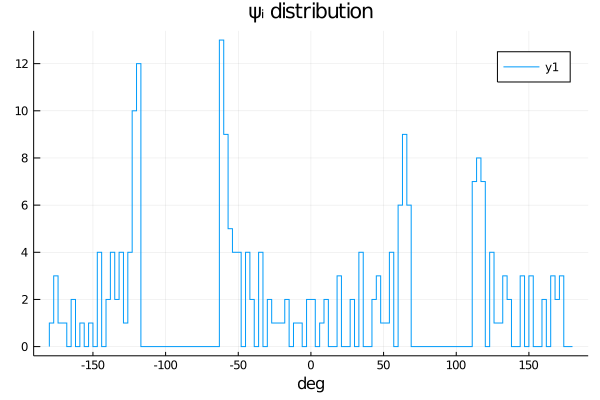

In [15]:
#print(Int.(Theta_line[1,:])[220])
#index = np.where(Int.(Theta_line[1,:]) .==52608)[1] .+1
pixnmb = 50
index = np.where(theta_line_pix .== phi90pix[pixnmb])[1] .+1

psi_in_ipix = zeros(length(index))
for i in 1:length(index)
    psi_in_ipix[i] = theta_line_psi[index[i]] 
end
ddeg = np.deg2rad(0.36)
print("pix=",phi90pix[pixnmb])

copol = np.reshape(data["copol"], [N, N])
copol_sym = MyPackage.rot_beam(psi_in_ipix, copol)

edge = -180:3:180

psi_dist = fit(Histogram, np.rad2deg(psi_in_ipix), edge)

Plots.plot(psi_dist,
    title = "ψᵢ distribution",
    xlabel="deg",
    seriestype = :step, fmt=:png)

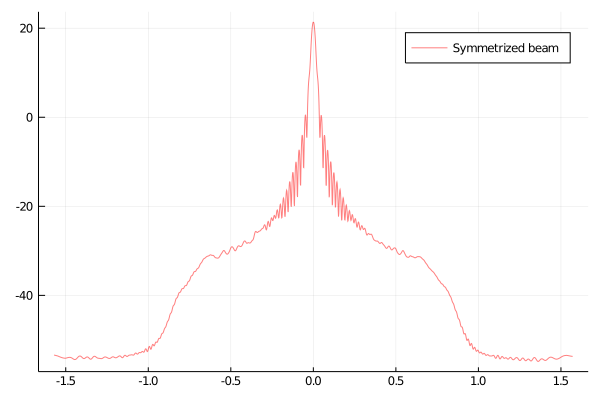

In [124]:
#Plots.plot( theta[:,1], 10log10.(copol[:,1]), color=:green, alpha=0.5, label="Origin beam", fmt=:png)
#Plots.plot!( -theta[:,500], 10log10.(copol[:,500]), color=:green, alpha=0.5, label=:none)

Plots.plot( theta[:,1], 10log10.(copol_sym[:,1]), color=:red, alpha=0.5, label="Symmetrized beam")
Plots.plot!( -theta[:,500], 10log10.(copol_sym[:,500]), color=:red, alpha=0.5, label=:none)



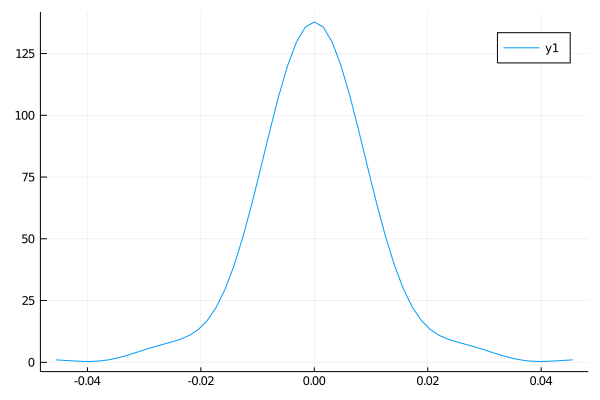

In [116]:
cut=30
a = [reverse(copol_sym[1:cut,1])  ;copol_sym[1:cut,1]]
b = [reverse(theta[1:cut,1]) ; -theta[1:cut,1]]
Plots.plot(b, a)


[136.84905158750715, 0.009105070326607448]
FWHM=73.70804823907702


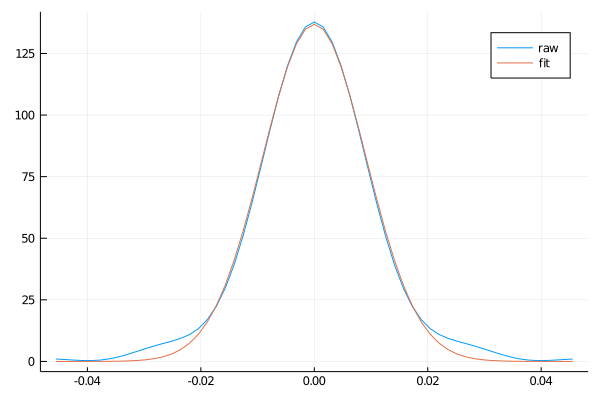

In [126]:
@. gaussian1(x, σ) = (1/(√(2π)*σ)) * exp(-(1/2)*((x/σ)^2))
@. gaussian2(x, p) = p[1] * exp(-(1/2)*((x/p[2])^2))

p0 = [136, 0.003]
xdata = b
ydata = a

Fit = curve_fit(gaussian2, xdata, ydata, p0)
println(Fit.param)

gauss = gaussian2(xdata, Fit.param)
FWHM = 2*√(2*log(2))*Fit.param[2]
println("FWHM=", np.rad2deg(FWHM)*60)

Plots.plot(xdata, ydata, label = "raw")
Plots.plot!(xdata, gauss, label = "fit")

In [ ]:
figure(111)
plt.title("Original beam")
pcolormesh(X, Y, 10log10.(copol), cmap = "jet" )
pp = plt.colorbar( orientation ="vertical")


figure(222)
plt.title("Symmetrized beam")
pcolormesh(X, Y, 10log10.(copol_sym), cmap = "jet" )
pp = plt.colorbar( orientation ="vertical")

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(X, Y, 10log10.(copol), cmap="jet", linewidth=0)
fig.colorbar(surf)
ax.set_title("Original beam")

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(X, Y, 10log10.(copol_sym), cmap="jet", linewidth=0)
fig.colorbar(surf)
ax.set_title("Symmetrized beam")

In [ ]:
radius = 501
beam_deg = np.rad2deg(theta[:,1])[radius]
println("cut_beam_theta=", beam_deg)
xticks_values = [0,π/2,π,3π/2,2π]
xticks_labels = ["0","π/2","π","3π/2","2π"]

Plots.plot(phi[1,:], copol[radius,:], alpha=1, xticks = (xticks_values,xticks_labels), label="Original Beam", fmt=:png)
Plots.plot!(phi[1,:], copol_sym[radius,:], alpha=1, xticks = (xticks_values,xticks_labels), label="Symmetrized Beam", fmt=:png)

#Plots.plot!(phi[1,:], real(_inv1), alpha=0.5)
#Plots.plot!(phi[1,:], real(_inv2), alpha=0.5)
#Plots.plot!(phi[1,:], cos.(2π*10 .*phi)[1,:], label="Symmetrize")


#Amp1, _inv1, freq1 = fourier(asym)
#Amp2, _inv2, freq2 = fourier(sym)

#Plots.plot(0:500, Amp1, yscale=:log10, label="Origin")
#Plots.plot!(0:500, Amp2, yscale=:log10, label="Symmetrize")


In [ ]:
Amp1, _inv1, freq1 = MyPackage.fourier(copol[radius,:])
Amp2, _inv2, freq2 = MyPackage.fourier(copol_sym[radius,:])
#Amp2, _inv2, freq2 = fourier(ones(N) .*0.4)
#Plots.plot(0:500, Amp1, yscale=:log10, label="Original", title="Fourier transform of a certain zenith angle(θ=π/2)", fmt=:png)
#Plots.plot!(0:500, Amp2, yscale=:log10, label="Symmetrized")
p = Plots.plot(Amp1, label="Original")
Plots.plot!(p, Amp2, 
    yscale=:log10,
    label="Symmetrized",
    title="Fourier transform of a certain zenith angle(θ=π/2)",
    fmt=:png
    )

In [ ]:
_N = 501
#Freq = FFTW.fftfreq(N)[1:_N]
Amp_sum= MyPackage.calc_beam_anisotropy(copol)[1:_N]
Ampsym_sum= MyPackage.calc_beam_anisotropy(copol_sym)[1:_N]
Plots.plot(0:500, Amp_sum[:] ./findmax(Amp_sum[:])[1], yscale=:log10, label="Original", title="Fourier transform of the entire beam of a pixel",fmt=:png)
Plots.plot!(0:500, Ampsym_sum[:] ./findmax(Amp_sum[:])[1], yscale=:log10, label="Symmetrized", fmt=:png)
#println(findmax(Amp_sum[:])[1])
#println(findmax(Ampsym_sum[:])[1])


In [ ]:
Amp_elev = MyPackage.calc_beamsym_at_elevation(copol, phi90pix, theta_line_pix, theta_line_psi)

In [ ]:
Plots.plot(0:500, Amp_sum[:] ./findmax(Amp_sum[:])[1], yscale=:log10, label="Original", fmt=:png, title="Symmetrization at pix(φ=π/2)")
Plots.plot!(0:500, Amp_elev[1:501][:] ./findmax(Amp_elev[1:501][:])[1], yscale=:log10, label="Symmetrized")